## Findings -:-

In this use case I tried to investigate how Naive Bayes performs if we use CountVectorizer as feature extractor. 

I also wanted to investigate how does lemmatization and Stemming can affect the model performace given the same text cleaning was used for both (cleaning html tags, stopwords, punctuations)

- Total training sentences,labels = 25000

- Total Validation sentences,labels = 10000

Below are the observations listed - 

1. Comparing Performance of Naive Bayes model

    Both lemmatizer(WordNetLemmatizer) and stemmer(PorterStemmer) performed quiet good with ~ 82% accuracy and f1-score around 83% & 81% for class 0 and 1 respectively. Since there were no significant class imbalance in both training and validation set, so the accuarcy_score would be a reliable metric in this case.

2. A little overfitting was noticed (accuracy on training sentences was ~88% and this is expected as I've used maximum_features for the Vecorizer to be 20000 only, so it might be the case that many of the words in the validation data may not be present in the training data during creating BoW. Default ngram_range = (1,1) was taken.

3. When used nltk.word_tokenize( ) on the stemmed sentences, it was seen that no. of tokens generated a little less than when used lemmatized senetences.

  - Total no. of tokens generated from Lemmatized sentences = 3041167
  - Total no. of tokens generated from Stemmed sentences = 3041155
  - % of unique tokens generated from Lemmatized sentences = 4.07%
  - % of unique tokens generated from Stemmed sentences = 3.44%

2. On using maximum_features = None crashes runtime Google Colab multiple times

## Import the necessary libraries

In [ ]:
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from bs4 import BeautifulSoup
from collections import defaultdict
import re
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.metrics import classification_report,roc_auc_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Create Training Data

In [ ]:
# Training set

ds = tfds.load('imdb_reviews', split='train', as_supervised=True)
#ds = ds.take(1)

training_sentences = []
training_labels = []

for text, label in tfds.as_numpy(ds):
  #print(text.decode('UTF-8'), type(label), label)
  training_sentences.append(text.decode('UTF-8')) #to convert bytes into strings
  training_labels.append(label)

In [ ]:
train_df = pd.DataFrame(np.column_stack((training_sentences,training_labels)), 
                        columns = ['Sentences', 'Labels'])
train_df.head()

,Sentences,Labels
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1


In [ ]:
train_df.shape

(25000, 2)

## Create Validation Data/Test Data

In [ ]:
# Validation set
ds = tfds.load('imdb_reviews', split='test', as_supervised=True)
ds = ds.take(10000)

valid_sentences = []
valid_labels = []

for text, label in tfds.as_numpy(ds):
  #print(text.decode('UTF-8'), type(label), label)
  valid_sentences.append(text.decode('UTF-8')) #to convert bytes into strings
  valid_labels.append(label)

valid_df = pd.DataFrame(np.column_stack((valid_sentences,valid_labels)), 
                        columns = ['Sentences', 'Labels'])
valid_df.head()

,Sentences,Labels
0,There are films that make careers. For George ...,1
1,"A blackly comic tale of a down-trodden priest,...",1
2,"Scary Movie 1-4, Epic Movie, Date Movie, Meet ...",0
3,Poor Shirley MacLaine tries hard to lend some ...,0
4,As a former Erasmus student I enjoyed this fil...,1


In [ ]:
valid_df.shape

(10000, 2)

## Text preprocessing

### Functions for preprocessing

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
 text = BeautifulSoup(text, "lxml").text # HTML decoding
 text = text.lower() # lowercase text
 text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
 text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
 text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
 return text

def stemming(sentence):
 
 stemmer = PorterStemmer()
 stemmed = [stemmer.stem(word) for word in sentence.split()]
 #stemSentence = stemSentence.strip()
 return ' '.join(stemmed)


# Lemmatizer function
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
lmtzr = WordNetLemmatizer()

def lemmatize(sentence):
  lemmatized_sentence = []
  tokens = word_tokenize(sentence)
  for token, tag in pos_tag(tokens):  # returns token and corresponding tag from list of tokens
    lemma = lmtzr.lemmatize(token, tag_map[tag[0]])
    #print(token, "=>", lemma)
    lemmatized_sentence.append(lemma)
  return ' '.join(lemmatized_sentence)



### Proprocessing Training Senetences



```
tokens = word_tokenize(train_df.loc[0,'Sentences'])

print(pos_tag(tokens))

[('absolutely', 'RB'), ('terrible', 'JJ'), ('movie', 'NN'), ('dont', 'NN'), ('lured', 'VBD'), ('christopher', 'JJR'), ('walken', 'NN'), ('michael', 'NN'), ('ironside', 'VBP'), ('great', 'JJ'), ('actors', 'NNS'), ('must', 'MD'), ('simply', 'RB'), ('worst', 'VB'), ('role', 'NN'), ('history', 'NN'), ('even', 'RB'), ('great', 'JJ'), ('acting', 'VBG'), ('could', 'MD'), ('redeem', 'VB'), ('movies', 'NNS'), ('ridiculous', 'JJ'), ('storyline', 'JJ'), ('movie', 'NN'), ('early', 'JJ'), ('nineties', 'NNS'), ('us', 'PRP'), ('propaganda', 'VBP'), ('piece', 'JJ'), ('pathetic', 'JJ'), ('scenes', 'NNS'), ('columbian', 'JJ'), ('rebels', 'NNS'), ('making', 'VBG'), ('cases', 'NNS'), ('revolutions', 'NNS'), ('maria', 'VBP'), ('conchita', 'JJ'), ('alonso', 'NN'), ('appeared', 'VBD'), ('phony', 'JJ'), ('pseudolove', 'NN'), ('affair', 'NN'), ('walken', 'IN'), ('nothing', 'NN'), ('pathetic', 'JJ'), ('emotional', 'JJ'), ('plug', 'NN'), ('movie', 'NN'), ('devoid', 'JJ'), ('real', 'JJ'), ('meaning', 'NN'), ('disappointed', 'JJ'), ('movies', 'NNS'), ('like', 'IN'), ('ruining', 'VBG'), ('actors', 'NNS'), ('like', 'IN'), ('christopher', 'NN'), ('walkens', 'NNS'), ('good', 'JJ'), ('name', 'NN'), ('could', 'MD'), ('barely', 'RB'), ('sit', 'VB')]
```






In [ ]:
train_df['Sentences'] = train_df['Sentences'].apply(lambda x : clean_text(x))
train_df.head()

,Sentences,Labels
0,absolutely terrible movie dont lured christoph...,0
1,known fall asleep films usually due combinatio...,0
2,mann photographs alberta rocky mountains super...,0
3,kind film snowy sunday afternoon rest world go...,1
4,others mentioned women go nude film mostly abs...,1


In [ ]:
train_df['Stemmed']  = train_df['Sentences'].apply(lambda x : stemming(x))
train_df.head()

,Sentences,Labels,Stemmed
0,absolutely terrible movie dont lured christoph...,0,absolut terribl movi dont lure christoph walke...
1,known fall asleep films usually due combinatio...,0,known fall asleep film usual due combin thing ...
2,mann photographs alberta rocky mountains super...,0,mann photograph alberta rocki mountain superb ...
3,kind film snowy sunday afternoon rest world go...,1,kind film snowi sunday afternoon rest world go...
4,others mentioned women go nude film mostly abs...,1,other mention women go nude film mostli absolu...


In [ ]:
train_df['Lemmatized'] =  train_df['Sentences'].apply(lambda x : lemmatize(x))
train_df.head(2)

,Sentences,Labels,Stemmed,Lemmatized
0,absolutely terrible movie dont lured christoph...,0,absolut terribl movi dont lure christoph walke...,absolutely terrible movie dont lure christophe...
1,known fall asleep films usually due combinatio...,0,known fall asleep film usual due combin thing ...,know fall asleep film usually due combination ...


In [ ]:
train_df['Lemmatized'][0]

'absolutely terrible movie dont lure christopher walken michael ironside great actor must simply worst role history even great act could redeem movie ridiculous storyline movie early ninety u propaganda piece pathetic scene columbian rebel make case revolution maria conchita alonso appear phony pseudolove affair walken nothing pathetic emotional plug movie devoid real meaning disappointed movie like ruin actor like christopher walkens good name could barely sit'

### Proprocessing Validation Senetences

In [ ]:
valid_df['Sentences'] = valid_df['Sentences'].apply(lambda x : clean_text(x)) # clean all punctuations, lowercase, remove stopwords
valid_df['Stemmed']  = valid_df['Sentences'].apply(lambda x : stemming(x)) # Stemming
valid_df['Lemmatized'] =  valid_df['Sentences'].apply(lambda x : lemmatize(x)) # Lemmatization
valid_df.head()

,Sentences,Labels,Stemmed,Lemmatized
0,films make careers george romero night living ...,1,film make career georg romero night live dead ...,film make career george romero night live dead...
1,blackly comic tale downtrodden priest nazarin ...,1,blackli comic tale downtrodden priest nazarin ...,blackly comic tale downtrodden priest nazarin ...
2,scary movie 14 epic movie date movie meet spar...,0,scari movi 14 epic movi date movi meet spartan...,scary movie 14 epic movie date movie meet spar...
3,poor shirley maclaine tries hard lend gravitas...,0,poor shirley maclain tri hard lend gravita maw...,poor shirley maclaine try hard lend gravitas m...
4,former erasmus student enjoyed film much reali...,1,former erasmu student enjoy film much realist ...,former erasmus student enjoy film much realist...


## Let's checkout the distributions of target in the training set & dev set and decide the performance metrics

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


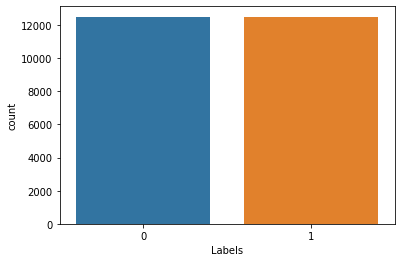

In [ ]:
sns.countplot(train_df['Labels'])

In [ ]:
train_df['Labels'].value_counts()

0    12500
1    12500
Name: Labels, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


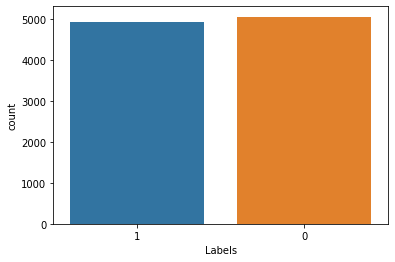

In [ ]:
sns.countplot(valid_df['Labels'])

In [ ]:
valid_df['Labels'].value_counts()

0    5061
1    4939
Name: Labels, dtype: int64

So, from the above plots we see both labels in training data and test data are quiet balanced. So we can use accuracy score as metrics in this case. But for now, I'll try to use f1-score as performance metric

## Let's create a BOW model with sklearn's CountVectorizer 
_We'll try with both lemmatized and stemmed texts to check is there difference in the performace of the model_

### Analysis of tokens in Lemmatized and Stemmed sentences

In [ ]:
# Lemmatized sentences
lemma_corpus = [word_tokenize(sentence) for sentence in train_df['Lemmatized']]
lemma_corpus = list(itertools.chain.from_iterable(lemma_corpus)) # to jooin the list of lists
print('Total no. of sentences tokenized:', len(train_df['Lemmatized']))
print('Unique tokens: ',len(set(lemma_corpus)))
print('Total no. of tokens: ',len(lemma_corpus))
print('% of unique tokens: ','{:.3f}'.format(len(set(lemma_corpus))/len(lemma_corpus)*100),' %')

Total no. of sentences tokenized: 25000
Unique tokens:  123767
Total no. of tokens:  3041167
% of unique tokens:  4.070  %


In [ ]:
lemma_corpus[:7]

['absolutely', 'terrible', 'movie', 'dont', 'lure', 'christopher', 'walken']

In [ ]:
# Stemmed Sentences
stem_corpus = [word_tokenize(sentence) for sentence in train_df['Stemmed']]
stem_corpus = list(itertools.chain.from_iterable(stem_corpus)) # to jooin the list of lists
print('Total no. of sentences tokenized:', len(train_df['Stemmed']))
print('Unique tokens: ',len(set(stem_corpus)))
print('Total no. of tokens: ',len(stem_corpus))
print('% of unique tokens: ','{:.3f}'.format(len(set(stem_corpus))/len(stem_corpus)*100),' %')

Total no. of sentences tokenized: 25000
Unique tokens:  104523
Total no. of tokens:  3041155
% of unique tokens:  3.437  %


In [ ]:
stem_corpus[:7]

['absolut', 'terribl', 'movi', 'dont', 'lure', 'christoph', 'walken']

From the above comparison we see that Lemmatization creates more no.of unique tokens than Stemming in this use case. If we see the total count of tokens 

In [ ]:
all_training_sentences_lemma = [sentence for sentence in train_df['Lemmatized']]
all_training_sentences_stem = [sentence for sentence in train_df['Stemmed']]
print(len(all_training_sentences_lemma))
print(len(all_training_sentences_stem))

25000
25000


In [ ]:
all_validation_sentences_lemma = [sentence for sentence in valid_df['Lemmatized']]
all_validation_sentences_stem = [sentence for sentence in valid_df['Stemmed']]
print(len(all_validation_sentences_lemma))
print(len(all_validation_sentences_stem))

10000
10000


### Let's create the BOWs

#### Lemma

In [ ]:
cvector_lemma = CountVectorizer(max_features = 20000)
lemma_train_bow = cvector_lemma.fit_transform(all_training_sentences_lemma).toarray()
lemma_train_bow.shape

(25000, 20000)

In [ ]:
lemma_test_bow = cvector_lemma.transform(all_validation_sentences_lemma)
lemma_test_bow.shape

(10000, 20000)

#### Stem

In [ ]:
cvector_stem = CountVectorizer(max_features = 20000)
stem_train_bow = cvector_stem.fit_transform(all_training_sentences_stem).toarray()
stem_train_bow.shape

(25000, 20000)

In [ ]:
stem_test_bow = cvector_stem.transform(all_validation_sentences_stem).toarray()
stem_test_bow.shape

(10000, 20000)

## Training a Naive Bayes Classifier

### Naive Bayes on Lemmatized Sentences

In [ ]:
classifier = MultinomialNB()
classifier.fit(lemma_train_bow,np.array(training_labels))
predicted_labels = classifier.predict(lemma_test_bow)
predicted_labels_train = classifier.predict(lemma_train_bow)

In [ ]:
print("Validation Set")
print(classification_report(np.array(valid_labels),predicted_labels))
print("Training Set")
print(classification_report(np.array(training_labels),predicted_labels_train))

Validation Set
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      5061
           1       0.85      0.76      0.81      4939

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

Training Set
              precision    recall  f1-score   support

           0       0.86      0.91      0.88     12500
           1       0.90      0.86      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



### Naive Bayes on Stemmed Sentences

In [ ]:
classifier2 = MultinomialNB()
classifier2.fit(stem_train_bow, np.array(training_labels))
predicted_labels_stem = classifier2.predict(stem_test_bow)
predicted_labels_stem_train = classifier2.predict(stem_train_bow)

In [ ]:
print("Validation Data")
print(classification_report(np.array(valid_labels),predicted_labels_stem))
print("Training Data")
print(classification_report(np.array(training_labels),predicted_labels_stem_train))

Validation Data
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      5061
           1       0.85      0.76      0.80      4939

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000

Training Data
              precision    recall  f1-score   support

           0       0.86      0.91      0.88     12500
           1       0.90      0.86      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

